# Dataset estadístico

In [11]:
import os
import pandas as pd
import numpy as np
import constants as ct
from kaggletoxicity.utils import get_upper_case_prop, get_punctuation_prop, process_text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
from tqdm import tqdm

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
pd.options.display.width = 1000
pd.options.display.max_colwidth = 200

X_train = pd.read_hdf(ct.STORE_PATH, 'X_train')
Y_train = pd.read_hdf(ct.STORE_PATH, 'Y_train')

X_full = pd.read_hdf(ct.STORE_PATH, 'X_full')

X_test = pd.read_hdf(ct.STORE_PATH, 'X_test')

flame_example = pd.read_hdf(ct.STORE_PATH, 'flame_example')
upper_cases_prop = flame_example.comment_text.map(get_upper_case_prop)
upper_cases_prop.describe()

Using TensorFlow backend.


count    20.000000
mean      0.163256
std       0.305791
min       0.000000
25%       0.007732
50%       0.035515
75%       0.103687
max       1.000000
Name: comment_text, dtype: float64

In [12]:
#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
#from wordcloud import WordCloud ,STOPWORDS
#from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settingsimread
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

# Exploración de comentarios

In [13]:
BLACK_LIST = pd.read_csv('arrBad', index_col=None, quotechar="'")
BLACK_LIST = BLACK_LIST.index

In [14]:
from kaggletoxicity.string_dists import *

https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda Calcula las palabras más comunes de los comentarios que ya estan clasificados

In [15]:
#check = X_train.loc[sample[0]].comment_text
#type(pd.Series(check.split()))
#dist_text_to_series('mother fucker nigga', BLACK_LIST)
dist_string_to_series('mother', BLACK_LIST)

0.0

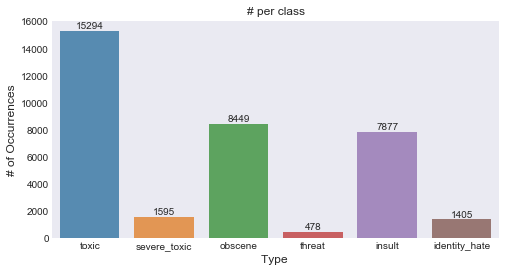

In [17]:
x=Y_train.iloc[:,:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


### StopWords

Limpiamos los textos quitando:

  - Stopwords

In [142]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string

stopw = set(stopwords.words('english'))
#print([i for i in word_tokenize(sentence.lower()) if i not in stop]) 
sentence = X_train['comment_text'][0]


sentence = ".join(".join(s)[:2] for _, s in intertools.groupby(sentence))
print(sentence)

sentence = tokenizer.tokenize(sentence)
#sentence = [w for w in sentence if not w in eng_stopwords]
#sentence =[APPO[word] if word in APPO else word for word in sentence]

" ".join(sentence)

SyntaxError: invalid syntax (<ipython-input-142-cfed8afd6a93>, line 11)

## Comentarios limpios
Creamos una columna con el numero de categorias de cada comentario, asi las que tengan _tagsn = 0_ seran los comentarios limpios

In [30]:
#merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
#df=merge.reset_index(drop=True)
#Y_train.iloc[:,0:2]
Y_train['tagsn'] = Y_train.sum(axis=1)
Y_train.head()
#suma = Y_train['toxic'] + Y_train['severe_toxic']  # a Series


,toxic,severe_toxic,obscene,threat,insult,identity_hate,tagsn
id,,,,,,,
0000997932d777bf,0,0,0,0,0,0,0
000103f0d9cfb60f,0,0,0,0,0,0,0
000113f07ec002fd,0,0,0,0,0,0,0
0001b41b1c6bb37e,0,0,0,0,0,0,0
0001d958c54c6e35,0,0,0,0,0,0,0


Calculamos ahora, respecto a los comentarios limpios diferentes features 

In [48]:
cleanseries = Y_train.loc[Y_train['tagsn'] == 0].index.to_series()
cleanseries.head()
#type(cleanseries)

AttributeError: 'Index' object has no attribute 'head'

In [66]:

clean_comments = X_train.loc[Y_train['tagsn'] == 0].comment_text
clean_comments_unique_word_count = clean_comments.map(lambda s:len(set(s.lower().split())))

In [78]:
clean_comments_unique_word_count.mean()

48.57924881057023

In [79]:
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

NameError: name 'df' is not defined